In [53]:
import numpy as np
import pandas as pd
import keras as k
import matplotlib.pyplot as plt

In [50]:
# Load MNIST dataset
MNIST = k.datasets.mnist.load_data(path="mnist.npz")
# Seperate dataset
training = MNIST[0]
X_train = training[0]
y_train = pd.Series(training[1], name="training targets")
testing = MNIST[1]
X_test = training[0]
y_test = pd.Series(testing[1], name="testing targets")
# Keep only 1s and 0s for binary classification problem
y_train = y_train[(y_train == 1) | (y_train == 0)]
X_train = X_train[y_train.index]
y_test = y_test[(y_test == 1) | (y_test == 0)]
X_test = X_test[y_test.index]

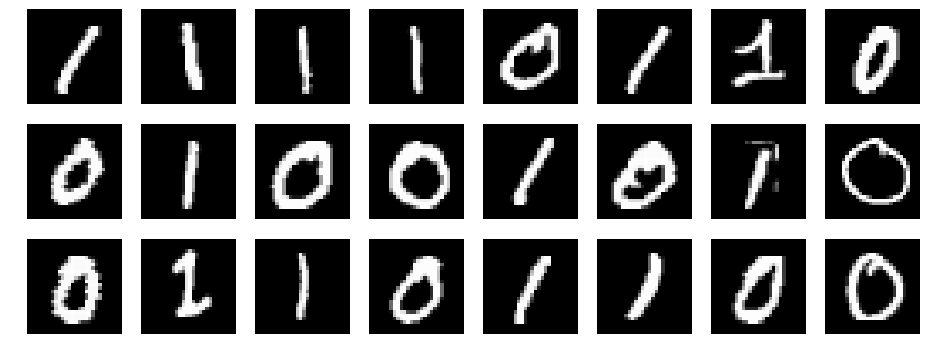

In [101]:
# Visualize training data
plt.figure(figsize=(16,6))
for i in range(24):
    fig = plt.subplot(3, 8, i+1)
    fig.set_axis_off()
    plt.imshow(X_train[i+1], cmap='gray')

In [102]:
def conv_single_step(a_slice_prev, W, b):
    """
    Apply one filter defined by parameters W on a single slice (a_slice_prev) of the output activation 
    of the previous layer.
    
    Arguments:
    a_slice_prev -- slice of input data of shape (f, f, n_C_prev)
    W -- Weight parameters contained in a window - matrix of shape (f, f, n_C_prev)
    b -- Bias parameters contained in a window - matrix of shape (1, 1, 1)
    
    Returns:
    Z -- a scalar value, the result of convolving the sliding window (W, b) on a slice x of the input data
    """
    
    # Element-wise product between a_slice_prev and W. Do not add the bias yet.
    s = np.multiply(a_slice_prev, W)
    # Sum over all entries of the volume s.
    Z = np.sum(s)
    # Add bias b to Z. Cast b to a float() so that Z results in a scalar value.
    Z = Z + float(b)

    return Z

In [103]:
def conv_forward(A_prev, W, b):
    """
    Implements the forward propagation for a convolution function
    
    Arguments:
    A_prev -- output activations of the previous layer, 
        numpy array of shape (m, n_H_prev, n_W_prev, n_C_prev)
    W -- Weights, numpy array of shape (f, f, n_C_prev, n_C)
    b -- Biases, numpy array of shape (1, 1, 1, n_C)
        
    Returns:
    Z -- conv output, numpy array of shape (m, n_H, n_W, n_C)
    cache -- cache of values needed for the conv_backward() function
    """
    
    # Retrieve dimensions from A_prev's shape
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape[0], A_prev.shape[1], A_prev.shape[2], A_prev.shape[3]
    
    # Retrieve dimensions from W's shape
    (f, f, n_C_prev, n_C) = W.shape[0], W.shape[1], W.shape[2], W.shape[3]
    
    # Compute the dimensions of the CONV output volume 
    n_H = n_H_prev - f + 1
    n_W = n_W_prev - f + 1
    
    # Initialize the output volume Z with zeros.
    Z = np.zeros([m, n_H, n_W, n_C])
    
    for i in range(m):                  # loop over the batch of training examples
        a_prev = A_prev[i]         # Select ith training example's activation
        for h in range(n_H):           # loop over vertical axis of the output volume
            # Find the vertical start and end of the current "slice" 
            vert_start = h
            vert_end = vert_start + f
            
            for w in range(n_W):       # loop over horizontal axis of the output volume
                # Find the horizontal start and end of the current "slice" 
                horiz_start = w
                horiz_end = horiz_start + f
                
                for c in range(n_C):   # loop over channels (= #filters) of the output volume
                                        
                    # Use the corners to define the (3D) slice of a_prev_pad 
                    a_slice_prev = A_prev[i, vert_start:vert_end, horiz_start:horiz_end, :]
                    
                    # Convolve the (3D) slice with the correct filter W and bias b, to get back one output neuron.
                    weights = W[:, :, :, c]
                    biases = b[:, :, :, c]
                    Z[i, h, w, c] = conv_single_step(a_slice_prev, weights, biases)
                                        
    
    # Making sure your output shape is correct
    assert(Z.shape == (m, n_H, n_W, n_C))
    
    # Save information in "cache" for the backprop
    cache = (A_prev, W, b)
    
    return Z, cache

In [121]:
# Test that conv_forward functions as expected
A_prev = np.array([[1,1,1,0,0],[0,1,1,1,0],[0,0,1,1,1],[0,0,1,1,0],[0,1,1,0,0]]).reshape(1,5,5,1)
W = np.array([[1,0,1],[0,1,0],[1,0,1]]).reshape(3,3,1,1)
b = np.array([0]).reshape(1,1,1,1)
Z, _ = conv_forward(A_prev, W, b)
pd.DataFrame(Z.reshape(3,3), dtype=int)

,0,1,2
0,4,3,4
1,2,4,3
2,2,3,4
